
# Signature WGAN for Time‑Series Forecasting (with `yfinance`)

This Colab notebook trains a **conditional Signature Wasserstein GAN (WGAN‑GP)** to forecast a financial time series.
It uses:

- **`yfinance`** to download prices
- **log returns** as the modeling target
- **Signatures** (via `signatory`) of the *augmented path (time + cumulative log price)* as inputs to the critic
- **Conditional generator**: given a *context window* of past returns, it generates the *next horizon* returns
- **WGAN‑GP** training
- Sampling a **forecast distribution** for the next `HORIZON` steps and plotting predictive bands

---



## 1) Setup & Installs
Run this cell once. If you're on Colab, enable **GPU**: *Runtime → Change runtime type → GPU*.


In [75]:

!pip -q install yfinance pandas numpy matplotlib tqdm

# Try to install signatory (differentiable path signatures). This may compile if wheels don't exist.
# We keep it best-effort and fall back gracefully if unavailable.
try:
    import torch
    import signatory  # noqa: F401
    SIGNATORY_AVAILABLE = True
except Exception as e:
    print("Installing signatory…")
    try:
        # Attempt a fresh install matching your Torch version
        import torch, sys, subprocess
        _ = subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "signatory"])
        import signatory  # noqa: F401
        SIGNATORY_AVAILABLE = True
        print("signatory installed successfully.")
    except Exception as e2:
        print("signatory could not be installed. Falling back to non-signature critic.")
        SIGNATORY_AVAILABLE = False

print("Torch version:", torch.__version__)
print("SIGNATORY_AVAILABLE:", SIGNATORY_AVAILABLE)


Torch version: 2.6.0+cu124
SIGNATORY_AVAILABLE: True



## 2) Imports, Config, and Utilities
Edit the **Config** block to change the ticker, dates, and model hyperparameters.


In [76]:

import math, os, random
from datetime import datetime

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import autograd

try:
    import signatory  # differentiable signatures
except Exception:
    signatory = None

# ---------- Config ----------
class Config:
    TICKER = "^GSPC"            # e.g., "AAPL", "^GSPC", "MSFT", "BTC-USD"
    START_DATE = "1990-01-01"
    END_DATE   = None          # None = today
    PRICE_COL  = "Close"   # yfinance column

    CONTEXT_LEN = 120           # past steps conditioning window
    HORIZON     = 60           # steps to forecast
    TRAIN_SPLIT = 0.8          # fraction for train

    BATCH_SIZE  = 128
    NUM_EPOCHS  = 100
    LR_G        = 2e-4
    LR_D        = 2e-4
    BETAS       = (0.5, 0.9)
    N_CRITIC    = 5            # critic steps per generator step
    GP_LAMBDA   = 10.0         # gradient penalty weight

    Z_DIM       = 64           # generator noise dimension
    HIDDEN      = 128          # hidden size for nets
    SIG_DEPTH   = 3            # signature depth (if signatory available)

    SEED        = 42
    DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"

cfg = Config()

# ---------- Reproducibility ----------
def set_seed(seed=cfg.SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.SEED)
print("Device:", cfg.DEVICE)


Device: cuda



## 3) Download Data & Create Returns
We use **log returns**. The model predicts returns; we later reconstruct price paths.


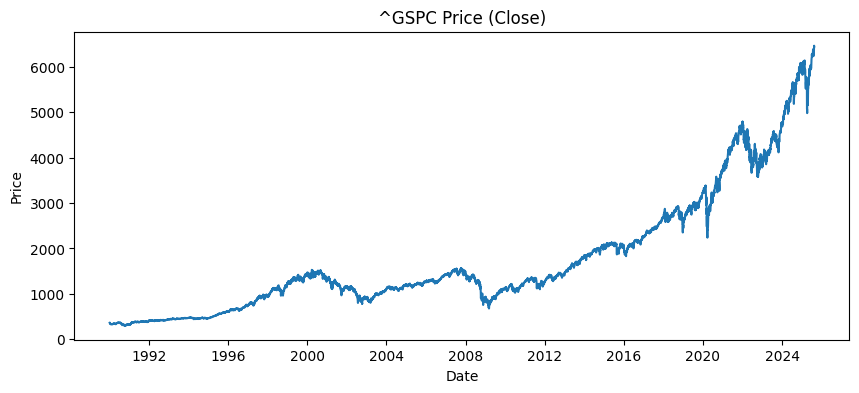

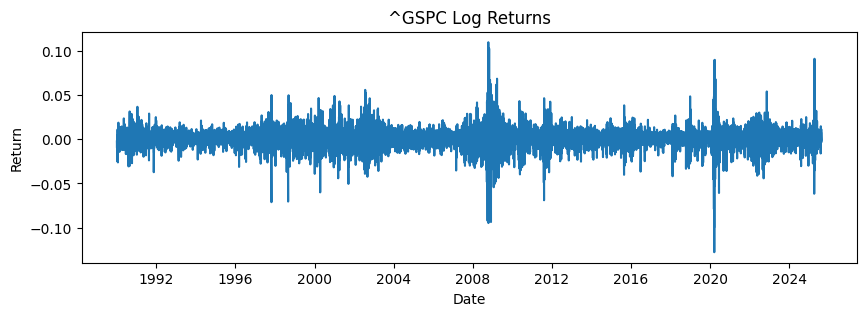

Total samples: 8971, Train: 7176, Test: 1795
Return mean/std (train): 0.000282/0.011075


In [77]:

if cfg.END_DATE is None:
    end = datetime.today().strftime("%Y-%m-%d")
else:
    end = cfg.END_DATE

data = yf.download(cfg.TICKER, start=cfg.START_DATE, end=end, progress=False, auto_adjust=True)
if data.empty:
    raise RuntimeError("No data downloaded. Check ticker/dates.")


cfg.PRICE_COL = "Close"

prices = data[cfg.PRICE_COL].dropna().astype(float)
logp = np.log(prices)
logret = logp.diff().dropna()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(prices.index, prices.values)
ax.set_title(f"{cfg.TICKER} Price ({cfg.PRICE_COL})")
ax.set_xlabel("Date"); ax.set_ylabel("Price")
plt.show()

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(logret.index, logret.values)
ax.set_title(f"{cfg.TICKER} Log Returns")
ax.set_xlabel("Date"); ax.set_ylabel("Return")
plt.show()

# Train/test split on return samples
rets = logret.values.astype(np.float32)
n = len(rets)
split_idx = int(cfg.TRAIN_SPLIT * n)
train_rets = rets[:split_idx]
test_rets  = rets[split_idx:]

# Standardize using train stats
mean_r = train_rets.mean()
std_r  = train_rets.std() + 1e-8
rets_z = (rets - mean_r) / std_r

print(f"Total samples: {n}, Train: {len(train_rets)}, Test: {len(test_rets)}")
print(f"Return mean/std (train): {mean_r:.6f}/{std_r:.6f}")



## 4) Dataset (Context → Future)
We form pairs: **context** window of length `CONTEXT_LEN`, and the **future** of length `HORIZON`.


In [78]:

class ContextFutureDataset(Dataset):
    def __init__(self, returns_z, context_len, horizon, start_idx=0, end_idx=None, stride=1):
        self.r = returns_z
        self.Lc = context_len
        self.H = horizon
        self.start = start_idx
        self.end = len(returns_z) if end_idx is None else end_idx
        self.stride = stride
        # number of usable windows
        self.n = max(0, (self.end - self.start) - (self.Lc + self.H) + 1)
    def __len__(self):
        return (self.n + (self.stride - 1)) // self.stride
    def __getitem__(self, idx):
        i = self.start + idx * self.stride
        ctx = self.r[i:i+self.Lc]
        fut = self.r[i+self.Lc:i+self.Lc+self.H]
        return torch.from_numpy(ctx).float(), torch.from_numpy(fut).float()

split_idx_z = int(cfg.TRAIN_SPLIT * len(rets_z))
train_ds = ContextFutureDataset(rets_z, cfg.CONTEXT_LEN, cfg.HORIZON, 0, split_idx_z)
test_ds  = ContextFutureDataset(rets_z, cfg.CONTEXT_LEN, cfg.HORIZON, split_idx_z, None)

train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_ds, batch_size=cfg.BATCH_SIZE, shuffle=False, drop_last=False)

print(f"Train windows: {len(train_ds)}, Test windows: {len(test_ds)}")


Train windows: 6997, Test windows: 1616



## 5) Signature Helpers
We build an **augmented path** with channels `[time, cumulative_log_price]` and compute signatures up to `SIG_DEPTH`.
If `signatory` is unavailable, we fall back to using the raw future sequence for the critic.


In [79]:

USE_SIGNATURE = (signatory is not None)
if USE_SIGNATURE:
    print("Using differentiable signatures (signatory).")
else:
    print("signatory unavailable → critic will see raw sequences (no signature transform).")

def build_path(seq2d):
    """seq2d: (B, L) standardized returns. Convert to path with channels [time, cum_log_price]."""
    B, L = seq2d.shape
    # cumulative log price (relative) from returns
    x = torch.cumsum(seq2d, dim=1)  # (B, L)
    x = x.unsqueeze(-1)             # (B, L, 1)
    # time channel in [0,1]
    t = torch.linspace(0, 1, steps=L, device=seq2d.device).unsqueeze(0).unsqueeze(-1).repeat(B, 1, 1)
    path = torch.cat([t, x], dim=-1)   # (B, L, 2)
    return path

def seq_to_signature(x_seq, depth):
    """x_seq: (B, L) → signature vector (B, Csig) for the path [time, cum_log_price]."""
    path = build_path(x_seq)
    C = path.shape[-1]
    Csig = signatory.signature_channels(channels=C, depth=depth)
    sig = signatory.signature(path, depth)  # (B, Csig)
    return sig

def context_future_signature(context, future, depth):
    full = torch.cat([context, future], dim=1)  # (B, Lc+H)
    return seq_to_signature(full, depth)

# Fallback feature maker if no signatory
def critic_features(context, future):
    if USE_SIGNATURE:
        return context_future_signature(context, future, cfg.SIG_DEPTH)
    else:
        # simple fallback: flatten [context||future] (no signature)
        return torch.cat([context, future], dim=1)


Using differentiable signatures (signatory).



## 6) Models: Conditional Generator & Signature Critic (WGAN‑GP)
- **Generator**: encodes context → combines with noise → MLP → future returns
- **Critic**: gets signature (or raw features in fallback) of `[context || future]` → scalar


In [80]:

class ContextEncoder(nn.Module):
    def __init__(self, in_len, hidden):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_len, hidden),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden, hidden),
            nn.LeakyReLU(0.2, inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class Generator(nn.Module):
    def __init__(self, context_len, z_dim, hidden, horizon):
        super().__init__()
        self.enc = ContextEncoder(context_len, hidden)
        self.fc = nn.Sequential(
            nn.Linear(hidden + z_dim, hidden),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden, hidden),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden, horizon),
        )
    def forward(self, context, z):
        # context: (B, Lc), z: (B, Z)
        h = self.enc(context)
        x = torch.cat([h, z], dim=1)
        out = self.fc(x)
        return out

class Critic(nn.Module):
    def __init__(self, in_dim, hidden):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden, hidden),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden, 1),
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

# determine critic input dimension
if USE_SIGNATURE:
    Csig = signatory.signature_channels(channels=2, depth=cfg.SIG_DEPTH)
    critic_in_dim = Csig
else:
    critic_in_dim = cfg.CONTEXT_LEN + cfg.HORIZON

G = Generator(cfg.CONTEXT_LEN, cfg.Z_DIM, cfg.HIDDEN, cfg.HORIZON).to(cfg.DEVICE)
D = Critic(critic_in_dim, cfg.HIDDEN).to(cfg.DEVICE)

opt_G = torch.optim.Adam(G.parameters(), lr=cfg.LR_G, betas=cfg.BETAS)
opt_D = torch.optim.Adam(D.parameters(), lr=cfg.LR_D, betas=cfg.BETAS)

print(f"Critic input dim: {critic_in_dim}")


Critic input dim: 14



## 7) Training Utilities
WGAN‑GP losses and helper functions.


In [81]:

def gradient_penalty(D, real_feat, fake_feat, device):
    B = real_feat.size(0)
    alpha = torch.rand(B, 1, device=device)
    alpha = alpha.expand_as(real_feat)
    interpolates = alpha * real_feat + (1 - alpha) * fake_feat
    interpolates.requires_grad_(True)

    d_interpolates = D(interpolates)
    grad_outputs = torch.ones_like(d_interpolates, device=device)

    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(B, -1)
    gp = ((gradients.norm(2, dim=1) - 1.0) ** 2).mean()
    return gp



## 8) Train
This may take a few minutes depending on GPU/CPU.


In [82]:

history = {"d_loss": [], "g_loss": []}

for epoch in range(cfg.NUM_EPOCHS):
    G.train(); D.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg.NUM_EPOCHS}", leave=False, disable=True)
    for i, (ctx, fut) in enumerate(pbar):
        # ensure shape is (B, L) not (B, L, 1)
        ctx = ctx.reshape(ctx.size(0), -1).to(cfg.DEVICE)
        fut = fut.reshape(fut.size(0), -1).to(cfg.DEVICE)

        # ---------------------
        #  Train Critic (n times)
        # ---------------------
        for _ in range(cfg.N_CRITIC):
            z = torch.randn(ctx.size(0), cfg.Z_DIM, device=cfg.DEVICE)
            fake_fut = G(ctx, z).detach()

            real_feat = critic_features(ctx, fut)
            fake_feat = critic_features(ctx, fake_fut)

            d_real = D(real_feat)
            d_fake = D(fake_feat)

            gp = gradient_penalty(D, real_feat, fake_feat, cfg.DEVICE) * cfg.GP_LAMBDA
            d_loss = (d_fake.mean() - d_real.mean()) + gp

            opt_D.zero_grad(set_to_none=True)
            d_loss.backward()
            opt_D.step()

        # ---------------------
        #  Train Generator
        # ---------------------
        z = torch.randn(ctx.size(0), cfg.Z_DIM, device=cfg.DEVICE)
        gen_fut = G(ctx, z)
        gen_feat = critic_features(ctx, gen_fut)
        g_loss = -D(gen_feat).mean()

        opt_G.zero_grad(set_to_none=True)
        g_loss.backward()
        opt_G.step()

        history["d_loss"].append(float(d_loss.detach().cpu()))
        history["g_loss"].append(float(g_loss.detach().cpu()))

        #pbar.set_postfix({"d": f"{history['d_loss'][-1]:.3f}", "g": f"{history['g_loss'][-1]:.3f}"})

    # end epoch
    # Optional: could add test metrics or early stopping

print("Training complete.")


Training complete.



## 9) Loss Curves


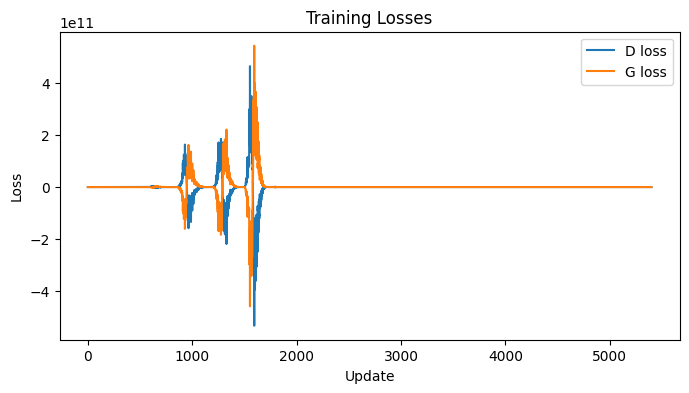

In [83]:

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(history["d_loss"], label="D loss")
ax.plot(history["g_loss"], label="G loss")
ax.set_title("Training Losses")
ax.set_xlabel("Update"); ax.set_ylabel("Loss"); ax.legend()
plt.show()



## 10) Forecasting: Sample Future Paths & Plot Predictive Bands
We take the **last context** from the series, draw many generated futures, then reconstruct **price** forecasts.


/tmp/ipython-input-1723325566.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_price = float(prices.iloc[-1])


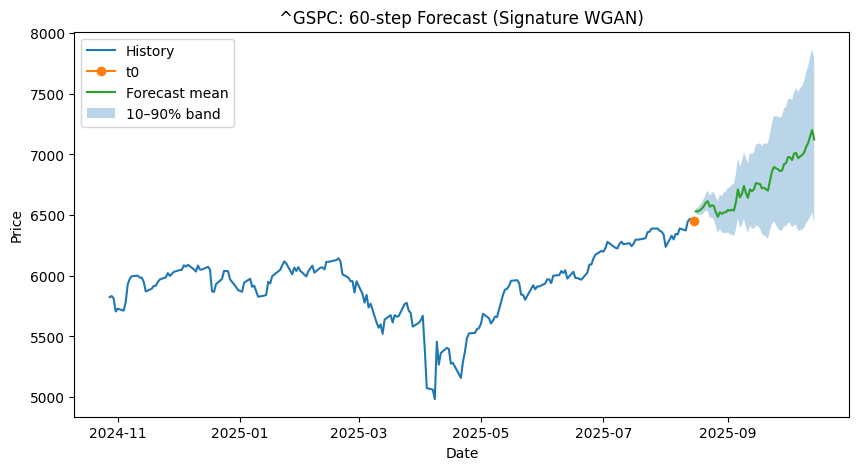

In [84]:

G.eval()
# last context from full standardized returns
context_full = torch.as_tensor(rets_z[-cfg.CONTEXT_LEN:], dtype=torch.float32, device=cfg.DEVICE).reshape(1, -1)

NUM_SAMPLES = 200  # number of forecast trajectories to sample
samples = []
with torch.no_grad():
    for _ in range(NUM_SAMPLES):
        z = torch.randn(1, cfg.Z_DIM, device=cfg.DEVICE)
        fut = G(context_full, z).squeeze(0).cpu().numpy()
        samples.append(fut)
samples = np.stack(samples, axis=0)  # (S, H)

# de-standardize returns
samples_real = samples * std_r + mean_r  # (S, H)

# reconstruct price paths starting from last known price
last_price = float(prices.iloc[-1])
# convert log returns to prices
price_paths = []
for s in samples_real:
    future_logp = np.cumsum(s)
    p = last_price * np.exp(future_logp)  # multiplicative returns from last_price
    price_paths.append(p)
price_paths = np.stack(price_paths, axis=0)  # (S, H)

# compute summary stats
mean_path = price_paths.mean(axis=0)
p10 = np.percentile(price_paths, 10, axis=0)
p90 = np.percentile(price_paths, 90, axis=0)

# build a combined plot: last 200 prices + forecast bands
past_N = 200
past_prices = prices.iloc[-past_N:]

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(past_prices.index, past_prices.values, label="History")
# future x-axis as integer steps
fut_x = np.arange(1, cfg.HORIZON+1)
ax.plot([past_prices.index[-1]], [past_prices.values[-1]], marker="o", label="t0")

ax.plot(past_prices.index[-1] + pd.to_timedelta(fut_x, unit="D"), mean_path, label="Forecast mean")
ax.fill_between(past_prices.index[-1] + pd.to_timedelta(fut_x, unit="D"), p10, p90, alpha=0.3, label="10–90% band")
ax.set_title(f"{cfg.TICKER}: {cfg.HORIZON}-step Forecast (Signature WGAN)")
ax.set_xlabel("Date"); ax.set_ylabel("Price")
ax.legend()
plt.show()



## 11) Sanity Check: Next‑Day Distribution
Compares generated *next‑step* return distribution against the empirical test returns (rough heuristic).


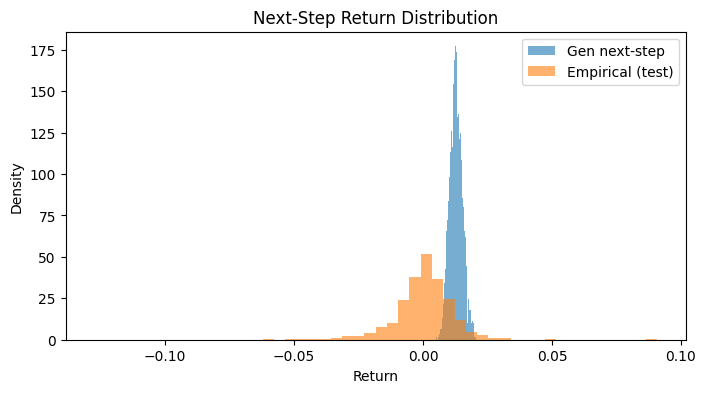

In [85]:

# Generated next-step returns (standardized) from the final context
with torch.no_grad():
    z = torch.randn(2000, cfg.Z_DIM, device=cfg.DEVICE)
    ctx_batch = context_full.repeat(2000, 1)
    gen_futs = G(ctx_batch, z).cpu().numpy()  # (2000, H)
gen_next_std = gen_futs[:, 0]
gen_next = gen_next_std * std_r + mean_r

emp_next = test_rets[:2000] if len(test_rets) > 0 else np.array([])

fig, ax = plt.subplots(figsize=(8,4))
ax.hist(gen_next, bins=50, alpha=0.6, density=True, label="Gen next-step")
if len(emp_next) > 0:
    ax.hist(emp_next, bins=50, alpha=0.6, density=True, label="Empirical (test)")
ax.set_title("Next‑Step Return Distribution")
ax.set_xlabel("Return"); ax.set_ylabel("Density")
ax.legend()
plt.show()



## 12) Tips & Customization
- Change `Config.TICKER`, `START_DATE`, `CONTEXT_LEN`, `HORIZON`, and training hyperparameters.
- Increase `NUM_EPOCHS` for better learning.
- Try other assets (e.g., `"^GSPC"`, `"MSFT"`, `"ETH-USD"`).
- If signature install fails, consider using a different Colab runtime or pinning Torch to a version with available `signatory` wheels.
- For multi‑asset or multi‑feature inputs, extend the dataset to include more channels and adapt the path builder accordingly.
